# DATASET
from Kaggle competition
https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images

There is 9 folders of images of most common Northern European mushrooms genuses inside of this dataset. Each folder consist of from 300 to 1500 selected images of mushrooms genuses. Labels are the folder's names.
Since amount of Data I have is a constraint I use the concept of Transfer Learning, which being said refers to technique which allows you to use the pretrained models on your own Dataset.
Here we are going to use VGG16 models. VGG16 is a Deep CNN trained over Imagenet Dataset which has around 1000 synsets. As, very well described in the paper Visualizing and Understanding Convolutional Networks the Bottom Layers of a Convolutional Neural Net activates only with primitive features (colour,texture,shape…) so these features can be transferred to other applications as well .Here we replace the fully Connected Layers and freeze the rest Layers so that they won't be trained.


# Training

First I use a CNN Network and train it over the training data it with default parameters and Adam optimizer. 

we use Pytorch pretrained VGG16 model and replace the fully connected layers and replace the fully connected layers and a softmax Layer of 9 units since we have 9 classes.
Make Sure you preprocess the input image the same way it is done in the VGG16 paper. Now since the Bottom layers are frozen, To avoid unnecessary computaion we can pass the input images once and save the Bootleneck features.
(The Best Hyperparameters after tuning were : Learning_rate:1e-3)

After 10 epochs: Training Loss: 0.284390, Validation Loss: 1.196293

After 30 epochs:

to avoid overfitting on the training dataset, I saved the model when it had the lowest validation loss. 

# Conclusion
see how can achieve a train a Decent model with even modicum data with the Help of Transfer learning.

In [22]:
#1
from glob import glob
import numpy as np

mushroom_files = np.array(glob('/floyd/input/mushrooms_dataset/*/*'))
mushroom_files

array(['/floyd/input/mushrooms_dataset/Entoloma/062_pAzSXyZENhg.jpg',
       '/floyd/input/mushrooms_dataset/Entoloma/186_yruDdMvb5iw.jpg',
       '/floyd/input/mushrooms_dataset/Entoloma/039_6oYbN68pG7c.jpg', ...,
       '/floyd/input/mushrooms_dataset/Hygrocybe/285_Nexh_hW9zpw.jpg',
       '/floyd/input/mushrooms_dataset/Hygrocybe/254_tfN6W-OGTQg.jpg',
       '/floyd/input/mushrooms_dataset/Hygrocybe/261_AvsaksXMXXk.jpg'],
      dtype='<U62')

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image

batch_size = 32
valid_size = .2
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],
                                                    [0.229,0.224,0.225])
])
data_dir = '/floyd/input/mushrooms_dataset'
image_dataset = datasets.ImageFolder(data_dir, transform)

train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
valid_size = int(0.2 * train_size)
train_size = train_size - valid_size

train_set, valid_set, test_set = torch.utils.data.random_split(image_dataset,[train_size, valid_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [3]:
#3
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

VGG16 = models.vgg16(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    VGG16.cuda()
for param in VGG16.parameters():
    param.requires_grad = False
VGG16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
#4
import torch.optim as optim
import torch.nn as nn

number_of_classes = len(image_dataset.classes)
classifier = nn.Sequential(nn.Linear(25088, 2500).cuda(),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(2500,250).cuda(),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(250, number_of_classes).cuda())
VGG16.classifier = classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16.classifier.parameters(), lr=0.001)

In [11]:
#5
from PIL import ImageFile
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader,valid_loader, model, optimizer, criterion, use_cuda, save_path):
    train_loss_values = []
    valid_loss_values = []
    
    valid_loss_min = np.Inf
    
    print(f"Batch Size: {train_loader.batch_size}\n")
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        train_loss_plt = 0.0
        valid_loss_plt = 0.0
        
        # train the model
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss_plt += loss.item()*data.size(0)
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch:{epoch}/{n_epochs} \tBatch:{batch_idx + 1}')
                print(f'Train Loss: {train_loss}\n')

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_loss_plt += loss.item()*data.size(0)
        # print training/validation statistics 
        
        
        train_loss_values.append(train_loss_plt/len(train_loader))
        valid_loss_values.append(valid_loss_plt/len(valid_loader)) 
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    plt.plot(train_loss_values, label='Training loss')
    plt.plot(valid_loss_values, label='Validation loss')
    plt.legend(frameon=False)        
    # return trained model
    return model

VGG16 = train(30, train_loader,valid_loader, VGG16, optimizer,
                       criterion, use_cuda, 'model_mushrooms.pt')

# load the model that got the best validation accuracy
VGG16.load_state_dict(torch.load('model_mushrooms.pt'))

Batch Size: 32

Epoch:1/30 	Batch:50
Train Loss: 1.7016818523406982

Epoch:1/30 	Batch:100
Train Loss: 1.6100976467132568

Epoch: 1 	Training Loss: 1.567182 	Validation Loss: 1.284640
Validation loss decreased (inf --> 1.284640). Saving model...
Epoch:2/30 	Batch:50
Train Loss: 1.2400659322738647

Epoch:2/30 	Batch:100
Train Loss: 1.1974045038223267

Epoch: 2 	Training Loss: 1.186304 	Validation Loss: 1.071086
Validation loss decreased (1.284640 --> 1.071086). Saving model...
Epoch:3/30 	Batch:50
Train Loss: 0.8984475135803223

Epoch:3/30 	Batch:100
Train Loss: 0.890749454498291

Epoch: 3 	Training Loss: 0.901270 	Validation Loss: 0.975139
Validation loss decreased (1.071086 --> 0.975139). Saving model...
Epoch:4/30 	Batch:50
Train Loss: 0.7101923227310181

Epoch:4/30 	Batch:100
Train Loss: 0.6748471260070801

Epoch: 4 	Training Loss: 0.691627 	Validation Loss: 1.160063
Epoch:5/30 	Batch:50
Train Loss: 0.5362368822097778

Epoch:5/30 	Batch:100
Train Loss: 0.5545982122421265

Epoch: 5 	

NameError: name 'plt' is not defined

In [13]:
VGG16.load_state_dict(torch.load('model_mushrooms.pt'))

<All keys matched successfully>

In [14]:
#6
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)       
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        output = F.softmax(output, dim=1)
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(test_loader, VGG16, criterion, use_cuda)

Test Loss: 0.935168


Test Accuracy: 71% (956/1343)


In [27]:
#7
class_name = [item[0:] for item in image_dataset.classes]
#class_name = []
#for item in image_dataset.classes:
#    class_name.append(item)
class_name

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [31]:
#8
def predict(img_path):

    img = Image.open(img_path)

    transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456,0.406],
                                                         [0.229,0.224,0.225])
    ])

    img_tensor = transform(img)[:3,:,:].unsqueeze(0)
#
    if use_cuda:
        img_tensor = img_tensor.cuda()
#
    VGG16.eval()
    with torch.no_grad():
        output = VGG16(img_tensor)
#        
    prediction = torch.argmax(output, dim=1).item()
    species = class_name[prediction]
    
    VGG16.train()
    
    return species

In [51]:
from PIL import Image
def run_app(img_path):
        plt.imshow(Image.open(img_path))
        plt.show()
        print(f'This is a picture of a ... {predict(img_path)}, actual: {img_path[31:-20]}')
        print('\n-----------------------------------\n')

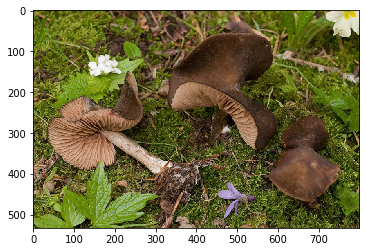

This is a picture of a ... Entoloma, actual: Entoloma

-----------------------------------



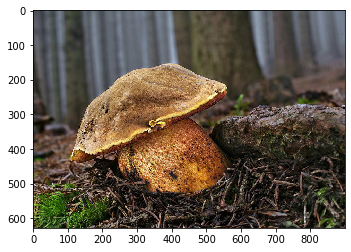

This is a picture of a ... Boletus, actual: Boletus/

-----------------------------------



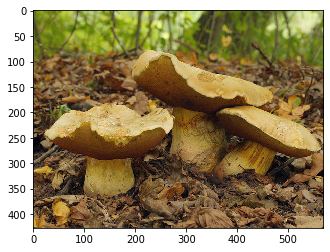

This is a picture of a ... Boletus, actual: Boletus/

-----------------------------------



In [56]:
#for file in np.hstack(mushroom_files[1600:1603]):
#    run_app(file)
run_app(mushroom_files[300])
run_app(mushroom_files[600])
run_app(mushroom_files[900])